# Emotion Detection

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Exploring Dataset

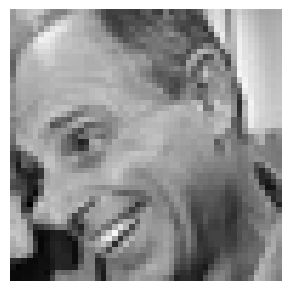

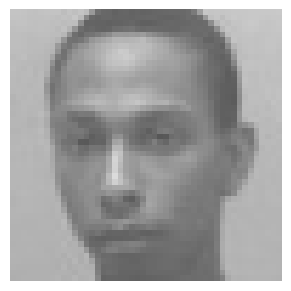

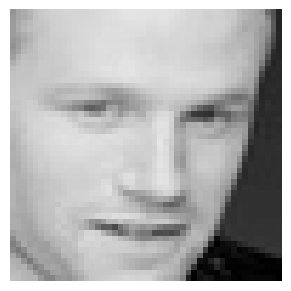

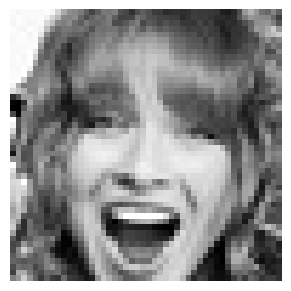

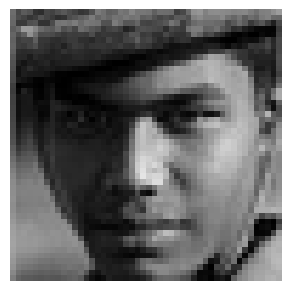

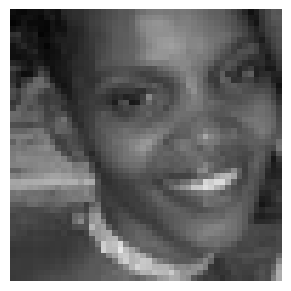

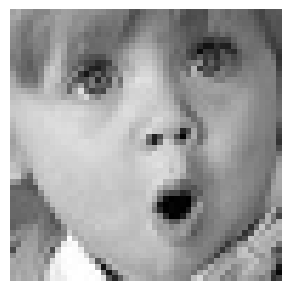

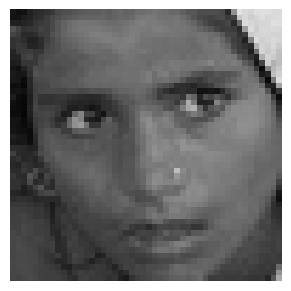

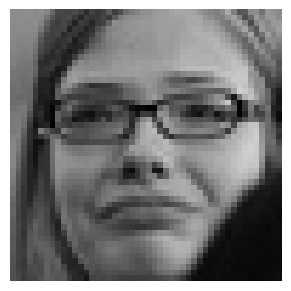

In [2]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing Data for Training

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size = (img_size, img_size), 
                                                    color_mode= "grayscale", 
                                                    batch_size=batch_size,
                                                   class_mode = "categorical", 
                                                    shuffle= True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size = (img_size, img_size), 
                                                    color_mode= "grayscale", 
                                                    batch_size=batch_size,
                                                   class_mode = "categorical", 
                                                    shuffle= True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Define Model

In [4]:
def convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x
    

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = convolution(inputs, 32,(3,3))
    conv_2 = convolution(inputs, 64,(5,5))
    conv_3 = convolution(inputs, 128,(3,3))
    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten, 256)
    output = Dense(7, activation = 'softmax')(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

## Initializing the Model

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor = 'val_accuracy', save_weights_only=True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

## Training the Model

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs= epochs,
    validation_data= validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15


C:\Users\Gaurav.DESKTOP-IOPIP0E\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3319 - loss: 1.8234
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - accuracy: 0.3320 - loss: 1.8230 - val_accuracy: 0.4015 - val_loss: 1.5471
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6:09 827ms/step - accuracy: 0.4375 - loss: 1.5413

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4375 - loss: 1.5413 - val_accuracy: 0.5000 - val_loss: 1.3421
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.4871 - loss: 1.3555
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 371s 824ms/step - accuracy: 0.4871 - loss: 1.3555 - val_accuracy: 0.4456 - val_loss: 1.4644
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:37 621ms/step - accuracy: 0.5469 - loss: 1.1081
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5469 - loss: 1.1081 - val_accuracy: 0.7000 - val_loss: 0.8688
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5608 - loss: 1.1767
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 290s 648ms/step - accuracy: 0.5608 - loss: 1.1767 - val_accuracy: 0.3747 - val_loss: 1.5575
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:41 629ms/step -

## Model Evaluation

In [10]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - accuracy: 0.4984 - loss: 1.5232


[1.5376667976379395, 0.492337703704834]

## Plotting Loss

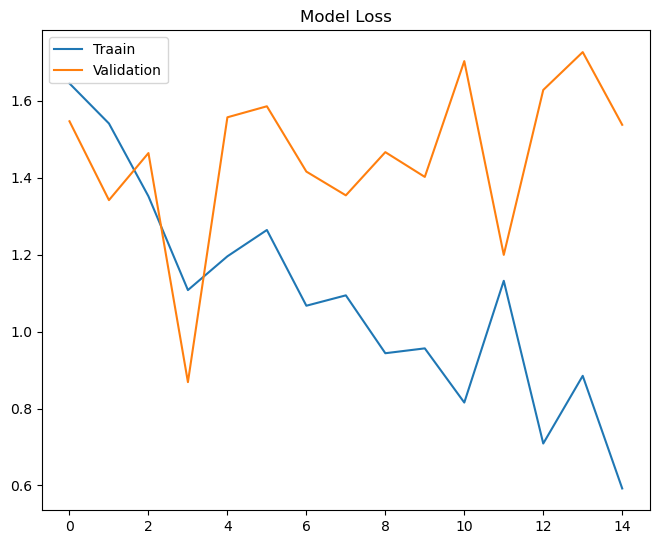

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Traain', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35);

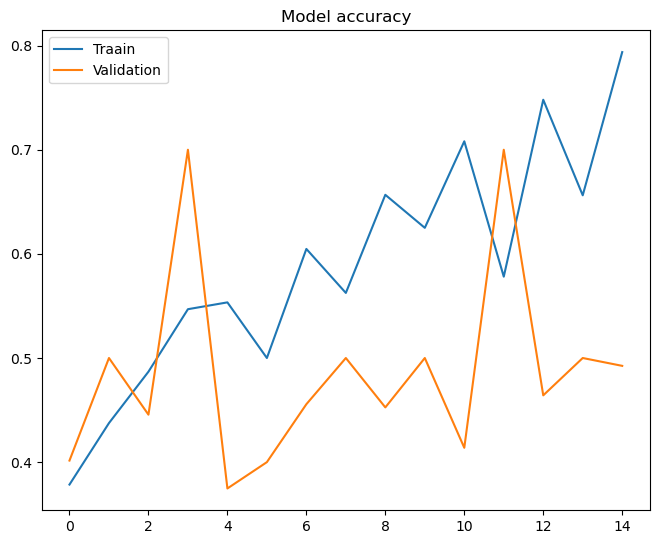

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Traain', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35);

## Saving Model

In [14]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)